In [67]:
%matplotlib inline

In [298]:
import numpy as np
import scipy.linalg as la
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from numba import jit

In [ ]:
def thred(z,delta):
    return np.sign(z)*(np.abs(z)>=delta)*(np.abs(z)-delta)

def ssvd(X,gamu = 2, gamv =2, merr = 10**(-4), niter = 100):
    n,d = X.shape
    #initial value of u and v
    U,s,VT = la.svd(X,full_matrices=False)
    u0 = U[:,0]
    v0 = VT.T[:,0]
    
    ud = 1
    vd = 1
    count = 0
    SST  = np.sum(X*X)
    
    while(ud>merr or vd>merr):
        count = count + 1
        
        # Update v
        z = X.T @ u0
        winv = np.abs(z)**gamv # weight inverse
        sigsq = np.abs(SST-np.sum(z*z))/(n*d-d)
        
        cand = z*winv  #candidate lambda
        delt = np.sort(np.append(np.abs(cand),0))
        delt_uniq = np.unique(delt)
        Bv = np.ones(len(delt_uniq)-1)*float("inf")
        
        ind = np.where(winv>10^(-8))
        cand1 = cand[ind]
        winv1 = winv[ind]
        for i in range(len(Bv)):
            temp2 = thred(cand1,delta = delt_uniq[i])
            temp2 = temp2/winv1
            temp3 = np.zeros(d)
            temp3[ind] = temp2
            Bv[i] = np.sum((X - u0[:,None] @ temp3[None,:])**2)/sigsq + np.sum(temp2!=0)*np.log(n*d)
        
        Iv = min(np.where(Bv== np.min(Bv))) #min BIC
        th = delt_uniq[Iv]
        temp2 = thred(cand1,delta = th)
        temp2 = temp2/winv1
        v1 = np.zeros(d)
        v1[ind] = temp2
        v1 = v1/(np.sqrt((np.sum(v1*v1)))) #v_new
        
        # Updating u
        z = X @ v1
        winu = np.abs(z)**gamu
        sigsq = np.abs(SST - np.sum(z*z))/(n*d-n)
        cand = z*winu
        delt = np.sort(np.append(np.abs(cand),0))
        delt_uniq = np.unique(delt)
        Bu = np.ones(len(delt_uniq)-1)*float("inf")
        ind = np.where(winu > 10^(-8))
        cand1 = cand[ind]
        winu1 = winu[ind]
        for i in range(len(Bu)):
            temp2 = thred(cand1,delta = delt_uniq[i])
            temp2 = temp2/winu1
            temp3 = np.zeros(n)
            temp3[ind] = temp2
            Bu[i] = np.sum((X - temp3[:,None] @ v1[None,:])**2)/sigsq + np.sum(temp2!=0)*np.log(n*d)
        Iu = min(np.where(Bu==np.min(Bu)))
        th = delt_uniq[Iu]
        temp2 = thred(cand1,delta = th)
        temp2 = temp2/winu1
        u1 = np.zeros(n)
        u1[ind] =  temp2
        u1 = u1/((np.sum(u1*u1))**0.5)
        
        
        ud = np.sqrt(np.sum((u0-u1)*(u0-u1)))
        vd = np.sqrt(np.sum((v0-v1)*(v0-v1)))
        
        if count > niter :
            print("Fail to converge! Increase the niter!")
            break
        
        u0 = u1
        v0 = v1
        
    s = u1[None, :] @ X @ v1[:, None] #ssvd layer is suv.T
    return u1, v1, s, count     

#  Rank-1 Approximation

In [300]:
u_ = np.arange(10,2,-1)
r1 = np.ones(17)*2
r2 = np.zeros(75)
u = np.concatenate([u_,r1,r2])
u = u/np.linalg.norm(u)
v_ = np.array([10,-10,8,-8,5,-5,3,3,3,3,3,-3,-3,-3,-3,-3])
r3 = np.zeros(34)
v = np.concatenate([v_,r3])
v = v/np.linalg.norm(v)
s = 50
X_star = s* u.reshape(len(u),1)@v.reshape(1,len(v))

In [29]:
u_zero = np.zeros(100)
v_zero = np.zeros(100)
uzero_correct = np.zeros(100)
vzero_correct = np.zeros(100)
unon_correct = np.zeros(100)
vnon_correct = np.zeros(100)
misclassification_u = np.zeros(100)
misclassification_v = np.zeros(100)
u_recode = (abs(u)>1e-6)*1
v_recode = (abs(v)>1e-6)*1

## SSVD

In [31]:
for i in range(100):
    X = X_star+np.random.normal(0,1,100*50).reshape(100,50)
    u1, v1, s, count = ssvd(X)
    u_zero[i] = sum(abs(u1)<1e-6)
    v_zero[i] = sum(abs(v1)<1e-6)
    u1_recode = (abs(u1)>1e-6)*1
    v1_recode = (abs(v1)>1e-6)*1
    u_table = confusion_matrix(u_recode,u1_recode)
    v_table = confusion_matrix(v_recode,v1_recode)
    uzero_correct[i] = u_table[0][0]
    vzero_correct[i] = v_table[0][0]
    unon_correct[i] = u_table[1][1]
    vnon_correct[i] = v_table[1][1]
    misclassification_u[i] = (u_table[0][1]+u_table[1][0])/100
    misclassification_v[i] = (v_table[0][1]+v_table[1][0])/50    

In [38]:
# Avg number of zeros(true)
(np.mean(u_zero),np.mean(v_zero))

(74.02, 33.76)

In [43]:
# Avg number of correctly identified zeros
(np.mean(uzero_correct),np.mean(vzero_correct))

(73.73, 33.76)

In [44]:
# percentage
(np.mean(uzero_correct/75),np.mean(vzero_correct/34))

(0.9830666666666665, 0.9929411764705884)

In [40]:
# Avg number of correctly identified nonzeros
(np.mean(unon_correct),np.mean(vnon_correct))

(24.71, 16.0)

In [45]:
# percentage
(np.mean(unon_correct/25),np.mean(vnon_correct/16))

(0.9883999999999997, 1.0)

In [41]:
# Misclassification rate
(np.mean(misclassification_u),np.mean(misclassification_v))

(0.015599999999999998, 0.0048)

## SVD

In [49]:
u_zero = np.zeros(100)
v_zero = np.zeros(100)
uzero_correct = np.zeros(100)
vzero_correct = np.zeros(100)
unon_correct = np.zeros(100)
vnon_correct = np.zeros(100)
misclassification_u = np.zeros(100)
misclassification_v = np.zeros(100)
u_recode = (abs(u)>1e-6)*1
v_recode = (abs(v)>1e-6)*1

In [50]:
for i in range(100):
    X = X_star+np.random.normal(0,1,100*50).reshape(100,50)
    U,S,VT = la.svd(X)
    u1 = U[:,0]
    v1 = VT[:,0]
    u_zero[i] = sum(abs(u1)<1e-6)
    v_zero[i] = sum(abs(v1)<1e-6)
    u1_recode = (abs(u1)>1e-6)*1
    v1_recode = (abs(v1)>1e-6)*1
    u_table = confusion_matrix(u_recode,u1_recode)
    v_table = confusion_matrix(v_recode,v1_recode)
    uzero_correct[i] = u_table[0][0]
    vzero_correct[i] = v_table[0][0]
    unon_correct[i] = u_table[1][1]
    vnon_correct[i] = v_table[1][1]
    misclassification_u[i] = (u_table[0][1]+u_table[1][0])/100
    misclassification_v[i] = (v_table[0][1]+v_table[1][0])/50    

In [51]:
# Avg number of zeros(true)
(np.mean(u_zero),np.mean(v_zero))

(0.0, 0.0)

In [52]:
# Avg number of correctly identified zeros
(np.mean(uzero_correct),np.mean(vzero_correct))

(0.0, 0.0)

In [53]:
# percentage
(np.mean(uzero_correct/75),np.mean(vzero_correct/34))

(0.0, 0.0)

In [54]:
# Avg number of correctly identified nonzeros
(np.mean(unon_correct),np.mean(vnon_correct))

(25.0, 16.0)

In [55]:
# percentage
(np.mean(unon_correct/25),np.mean(vnon_correct/16))

(1.0, 1.0)

In [56]:
# Misclassification rate
(np.mean(misclassification_u),np.mean(misclassification_v))

(0.75, 0.6800000000000002)

# Higher rank approximation

In [319]:
X_star = np.zeros(100*50).reshape(50,100)

In [320]:
for i in range(50):
    for j in range(26,76):
        t = (24**2-(i-25)**2-(j-50)**2)/100
        if abs(t)>1:
            X_star[i,j] = t
        else:
            X_star[i,j] = 0    
X_star = X_star/np.max(X_star)

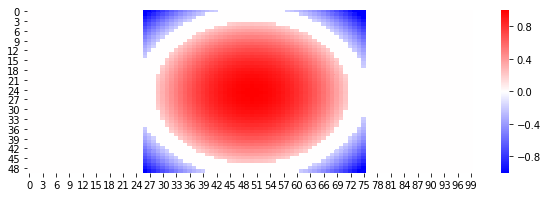

In [323]:
plt.figure(figsize=(10,3))
sns.heatmap(X_star,vmin=-1, vmax=1,cmap="bwr")
plt.savefig("simulation2.eps")
pass

In [281]:
X_true = (abs(np.ravel(X_star,order = "C"))>1e-6)*1

In [282]:
X_rate = np.zeros(9)

In [283]:
for k in range(1,10):
    X = X_star+np.random.normal(0,1,100*50).reshape(50,100)
    U,S,Vt = la.svd(X)
    layer = S[:k] * U[:,:k] @ Vt[:k,:]
    layer_true = (abs(np.ravel(layer,order = "C"))>1e-6)*1
    table_matrix = confusion_matrix(X_true,layer_true)
    X_rate[k-1] = (table_matrix[0][0]+table_matrix[1][1])/5000

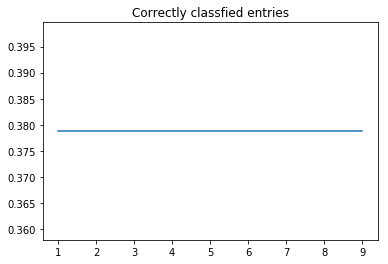

In [284]:
plt.plot(list(range(1,10)),X_rate)
plt.title("Correctly classfied entries")
pass

### SSVD layer1

In [289]:
X = X_star+np.random.normal(0,1,100*50).reshape(50,100)
u1, v1, s, count = ssvd(X)
layer1 = s * u1[:, None] * v1[None, :]
layer_true = (abs(np.ravel(layer1,order = "C"))>1e-6)*1
table_matrix = confusion_matrix(X_true,layer_true)
(table_matrix[0][0]+table_matrix[1][1])/5000

0.784

### layer2

In [290]:
X2 = X-layer1
u2, v2, s2, count2 = ssvd(X2)
layer2 = s2 * u2[:, None] * v2[None, :]
layer_2 = layer1+layer2
layer_true = (abs(np.ravel(layer_2,order = "C"))>1e-6)*1
table_matrix = confusion_matrix(X_true,layer_true)
(table_matrix[0][0]+table_matrix[1][1])/5000

0.7842

### layer3

In [291]:
X3 = X2-layer2
u3, v3, s3, count3 = ssvd(X3)
layer3 = s3 * u3[:, None] * v3[None, :]
layer_3 = layer1+layer2+layer3
layer_true = (abs(np.ravel(layer_3,order = "C"))>1e-6)*1
table_matrix = confusion_matrix(X_true,layer_true)
(table_matrix[0][0]+table_matrix[1][1])/5000

0.784